In [1]:
import json
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import multiprocessing
import numpy as np
import shutil 
import preprocessor as p

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS 

# Set of stopwords from Stone, Denis, Kwantes
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk import classify
from nltk import NaiveBayesClassifier

from textblob import TextBlob
import itertools 

import pickle

from sklearn.linear_model import LinearRegression
import pandas_profiling

import statsmodels.api as sm

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vinhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# function to search for words in a tweet
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

def keyword_column_boolean(df, keyword_list):
    for x in keyword_list:
        df[x] = df['text'].apply(lambda text: word_in_text(x,text))

#function to perform lemmatize and stem preprocessing
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

# sentiment analysis
def get_tweet_polarity(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(tweet)
        # set sentiment
        return analysis.sentiment.polarity

def get_tweet_sentiment(polarity):
        if polarity > 0:
            return 'positive'
        elif polarity == 0:
            return 'neutral'
        else:
            return 'negative'

def bag_of_words(tweet, all_text):
    words = all_text
    words_dictionary = dict([word, True] for word in words)
    return words_dictionary

def load_US_coord_dict():
    '''
    Input: n/a
    Output: A dictionary whose keys are the location names ('City, State') of the
    378 US classification locations and the values are the centroids for those locations
    (latitude, longittude)
    '''

    pkl_file = open("GeoData/US_coord_dict.pkl", 'rb')
    US_coord_dict = pickle.load(pkl_file)
    pkl_file.close()
    return US_coord_dict

def find_dist_between(tup1, tup2):
    '''
    INPUT: Two tuples of latitude, longitude coordinates pairs for two cities
    OUTPUT: The distance between the cities
    '''

    return np.sqrt((tup1[0] - tup2[0])**2 + (tup1[1] - tup2[1])**2)

def closest_major_city(tup):
    '''
    INPUT: A tuple of the centroid coordinates for the tweet to remap to the closest major city
    OUTPUT: String, 'City, State', of the city in the dictionary 'coord_dict' that is closest to the input city
    '''

    d={}
    for key, value in US_coord_dict.items():
        dist = find_dist_between(tup, value)
        if key not in d:
            d[key] = dist
    return min(d, key=d.get)

def get_closest_major_city_for_US(row):
    '''
    Helper function to return the closest major city for US users only. For users
    outside the US it returns 'NOT_IN_US, NONE'
    '''
    return closest_major_city(row['coordinate_point'])


### Pre-processing

In [3]:
#Combine all files into one

# with open('output_file.txt','wb') as wfd:
#     for f in ['twitter_data.txt','twitter_data_c2.txt',
#               'twitter_data_c2_pt2.txt','twitter_data_c2_pt3.txt', 
#               'twitter_data_c2_pt4.txt', 'twitter_data_c2_pt5.txt', 
#               'twitter_data_c2_pt6.txt', 'twitter_data_c2_pt7.txt',
#              'twitter_data_c2_pt8.txt','twitter_data_c2_pt9.txt',
#               'twitter_data_c2_pt10.txt','twitter_data_c2_pt11.txt']:
#         with open(f,'rb') as fd:
#             shutil.copyfileobj(fd, wfd)

### Read in and subset data

In [4]:
#read in data as chunks
df = pd.read_json('output_file.txt', lines = True)

In [5]:
#only keep variables needed
df = df[["id_str", "text", "place", "coordinates", "created_at", "lang", "possibly_sensitive","retweeted" ]]

In [6]:
#don't include retweets
keyword_column_boolean(df, ['RT'])
print("full df:", len(df))
df = df[df['RT']==False]
print("after RT removal:", len(df))

full df: 97816
after RT removal: 53176


In [7]:
#booleans for each diet
diet_list = ['keto','whole30','glutenfree','mediterraneandiet','lowfat', 'atkins', 'paleo', 'celeryjuice']
keyword_column_boolean(df, diet_list)

In [8]:
# create a new column called diet for pie chart
conditions = [
    (df['keto'] == True),
    (df['whole30'] == True),
    (df['glutenfree'] == True),
    (df['mediterraneandiet'] == True),
    (df['lowfat'] == True),
    (df['atkins'] == True),
    (df['paleo'] == True),
    (df['celeryjuice'] == True)]
choices = ['Keto', 'Whole30', 'GlutenFree','MediterraneanDiet','Lowfat','Atkins','Paleo',"CeleryJuice"]
df['diet'] = np.select(conditions, choices)


In [9]:
#fix Place field
#fill None with 0
filled = df['place'].fillna(0)
#replace old column
df["place"] = filled

In [10]:
# #mask
place = df[df['place'] != 0]
place.reset_index(inplace=True)

#pull out bounding box from place
df_place = [i for i in df["place"] if i] 
df_place_2 = pd.DataFrame(list(np.array(df_place)))

city = df_place_2[["name","country_code"]]

bounding_box = pd.DataFrame(list(np.array(df_place_2["bounding_box"])))
bounding_box.rename(columns={'coordinates': 'bounding_box'}, inplace=True)

#add to original df to get df we want
df_location = pd.concat([place, bounding_box], axis=1, join='inner')
df_location = pd.concat([df_location, city], axis=1, join='inner')
print("has location data:", len(df_location))

has location data: 2692


In [11]:
pie = df[df['diet'] != '0']
pie['diet'].value_counts(normalize=True)*100

Keto                 74.082622
GlutenFree            8.803241
Paleo                 8.057030
Atkins                6.662051
Whole30               1.377029
Lowfat                0.697490
MediterraneanDiet     0.189758
CeleryJuice           0.130779
Name: diet, dtype: float64

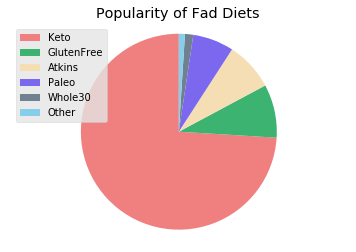

In [12]:
diet_percents = np.array([74.08, 8.8, 8.05, 6.77, 1.37, .69+.18+.13])
labels = 'Keto', 'GlutenFree','Atkins','Paleo','Whole30','Other'
color=['lightcoral', 'mediumseagreen', 'wheat', 'mediumslateblue', 'slategray','skyblue']
fig1, ax1 = plt.subplots()
ax1.pie(diet_percents, colors=color,
    startangle=90)
ax1.legend(labels, loc="best")
ax1.axis('equal')

ax1.set_title('Popularity of Fad Diets')
fig1.savefig('Popularity_of_fad_diets.png')

In [13]:
#limit to only english for analysis
df_location = df_location[df_location['lang'] == 'en']
print("after english removal df_location:", len(df_location))
df_eng = df[df['lang'] == 'en']
print("after english removal df_eng:", len(df_eng))

after english removal df_location: 2154
after english removal df_eng: 43716


In [14]:
#limit to only US for analysis
df_location = df_location[df_location['country_code'] == 'US']
print("after non-US removal:", len(df_location))

after non-US removal: 1494


In [15]:
#clean tweets - remove URLs, smileys, mentions, emojis

p.set_options(p.OPT.URL, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.EMOJI) 


text_list = list(df_eng["text"])

clean_text_list = []
for tweet in text_list:   
    clean_text_list.append(p.clean(tweet))

df_eng["text_clean"] = clean_text_list 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [16]:
#manually delete for now. eventually would like to do a hieararchy where if place is missing 
# and coordinates is not, fill with coordinates

df_eng = df_eng[df_eng["id_str"] != 1141697585700204544]

In [17]:
#fix index
df_location2 = df_eng.reset_index()

In [18]:
df_location3 = df_location2.drop(["index"], axis = 1)
df_location3['index'] = df_location3.index

#final df
df_clean = df_location3

In [19]:
len(df_clean)

43715

### Topic modeling using LDA

In [20]:
stemmer = PorterStemmer()

# create a new frame with only the cleaned text (tweet) and index
documents_v = df_clean[['text_clean', "index"]]

print(documents_v[:10])

                                          text_clean  index
0  New Edition of My West Indian Diaspora. Storie...      0
1  I lost a 42lbs last year on keto, and 6" off m...      1
2  Bass isnt wrong. He's objective.. which is way...      2
3           Won’t fit us fat fuckers . Keto anyone ?      3
4  Giddy up! I’ve been trying to make the perfect...      4
5  I need to get back on my keto diet I couldn’t ...      5
6  Proud of myself today! First pool workout in a...      6
7  #GrainFree Chocolate #Cake! Made in the blende...      7
8  Another sane, balanced message. The Keto commu...      8
9                   Primal (and Keto) Cowboy Burgers      9


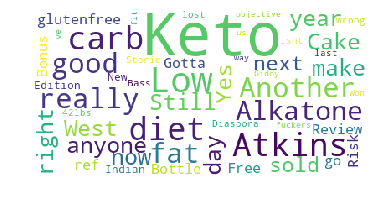

In [21]:
#Word cloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=50,
                          max_font_size=70, 
                          random_state=42,
                          collocations=False
                         ).generate(str(documents_v["text_clean"]))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1800)

In [22]:
#compare a tweet before and after preprocessing
doc_sample = documents_v[documents_v['index'] == 9].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Primal', '(and', 'Keto)', 'Cowboy', 'Burgers']


 tokenized and lemmatized document: 
['primal', 'keto', 'cowboy', 'burger']


In [23]:
#Apply to all tweets
processed_docs = documents_v['text_clean'].map(preprocess)

print(processed_docs[:11])

0     [edit, west, indian, diaspora, stori, keto, tr...
1     [lose, year, keto, waist, blood, go, entir, no...
2                           [bass, isnt, wrong, object]
3                                        [fucker, keto]
4         [giddi, tri, perfect, keto, wedg, like, year]
5     [need, keto, diet, couldn, stay, away, pizza, ...
6     [proud, today, pool, workout, long, time, keto...
7     [grainfre, chocol, cake, blender, real, food, ...
8     [sane, balanc, messag, keto, commun, consid, t...
9                        [primal, keto, cowboy, burger]
10                                                   []
Name: text_clean, dtype: object


In [55]:
# Bag of Words 
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
# Filter out tokens that appear in
# less than 20 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.


dictionary.filter_extremes(no_below=50, no_above=0.5, keep_n=200000)
print(dictionary)

0 diaspora
1 edit
2 indian
3 keto
4 stori
5 travelblog
6 west
7 blood
8 entir
9 go
10 lose
Dictionary(924 unique tokens: ['indian', 'stori', 'blood', 'entir', 'go']...)


In [56]:
#create bag of words. Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:10]

[[(0, 1), (1, 1)],
 [(2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1)],
 [],
 [(7, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(42, 1), (43, 1)]]

In [57]:
# TF-IDF
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7657616799666647), (1, 0.643124443241455)]


In [58]:
# LDA using Bag of Words and gensim

lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=5, 
                                       id2word=dictionary, 
                                       passes=2, 
                                       workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.058*"atkin" + 0.025*"like" + 0.022*"look" + 0.019*"meal" + 0.017*"good" + 0.017*"diet" + 0.013*"come" + 0.013*"peopl" + 0.013*"follow" + 0.012*"thing"
Topic: 1 
Words: 0.060*"diet" + 0.047*"food" + 0.044*"paleo" + 0.026*"year" + 0.024*"want" + 0.020*"carb" + 0.017*"pork" + 0.015*"eat" + 0.015*"protein" + 0.013*"week"
Topic: 2 
Words: 0.048*"weight" + 0.039*"diet" + 0.033*"lose" + 0.027*"carb" + 0.026*"fast" + 0.023*"loss" + 0.019*"help" + 0.019*"work" + 0.016*"cake" + 0.016*"recip"
Topic: 3 
Words: 0.078*"diet" + 0.028*"thank" + 0.027*"best" + 0.025*"ketogen" + 0.023*"ketodiet" + 0.022*"recip" + 0.021*"vegan" + 0.021*"latest" + 0.018*"paleo" + 0.018*"lowcarb"
Topic: 4 
Words: 0.055*"free" + 0.035*"glutenfre" + 0.031*"recip" + 0.026*"gluten" + 0.016*"carb" + 0.016*"paleo" + 0.016*"chocol" + 0.016*"pizza" + 0.015*"cooki" + 0.015*"vegan"


In [59]:
# Running LDA using TF-IDF

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=5, 
                                             id2word=dictionary, 
                                             passes=2, 
                                             workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.026*"diet" + 0.023*"weight" + 0.021*"lose" + 0.018*"loss" + 0.017*"fast" + 0.014*"carb" + 0.014*"best" + 0.014*"ketodiet" + 0.013*"ketosi" + 0.013*"help"
Topic: 1 Word: 0.031*"diet" + 0.018*"free" + 0.016*"paleo" + 0.014*"gluten" + 0.013*"recip" + 0.012*"chocol" + 0.012*"look" + 0.012*"carb" + 0.011*"cake" + 0.011*"cream"
Topic: 2 Word: 0.017*"food" + 0.016*"meal" + 0.015*"diet" + 0.014*"recip" + 0.013*"plan" + 0.013*"pork" + 0.013*"want" + 0.011*"year" + 0.011*"vegan" + 0.010*"free"
Topic: 3 Word: 0.037*"atkin" + 0.016*"right" + 0.015*"pizza" + 0.014*"diet" + 0.013*"coupon" + 0.012*"paleo" + 0.011*"enter" + 0.011*"commerci" + 0.011*"work" + 0.011*"seri"
Topic: 4 Word: 0.021*"glutenfre" + 0.021*"thank" + 0.017*"latest" + 0.016*"friendli" + 0.011*"daili" + 0.011*"atkin" + 0.010*"chees" + 0.010*"coffe" + 0.009*"diet" + 0.009*"paleo"


In [29]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score bow: ', coherence_lda)
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score tfidf: ', coherence_lda)



Coherence Score bow:  0.20855427786294323

Coherence Score tfidf:  0.23087528978501837


In [30]:
# Compute perplexity
print('\nPerplexity bow: ', lda_model.log_perplexity(bow_corpus))
print('\nPerplexity tfidf: ', lda_model_tfidf.log_perplexity(corpus_tfidf))
#tf-idf model is better


Perplexity bow:  -6.641780457131827

Perplexity tfidf:  -7.630333564206498


In [31]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060615 -0.215143       1        1  22.648457
4      0.174693 -0.019819       2        1  21.158361
3      0.159274  0.063060       3        1  20.425068
2     -0.242866  0.067718       4        1  18.527821
1     -0.030486  0.104184       5        1  17.240297, topic_info=     Category         Freq        Term        Total  loglift  logprob
144   Default  1357.000000        free  1357.000000  30.0000  30.0000
16    Default  2836.000000        diet  2836.000000  29.0000  29.0000
250   Default   576.000000      gluten   576.000000  28.0000  28.0000
137   Default   818.000000      weight   818.000000  27.0000  27.0000
94    Default  1122.000000   glutenfre  1122.000000  26.0000  26.0000
113   Default   676.000000       vegan   676.000000  25.0000  25.0000
21    Default   372.000000       pizza   372.000000  24.0000  24.0000
96    Default   433.000000        week   433.000000  23.0000  23.0000
82    Default  1004.000000       atkin  1004.000000  22.0000  22.0000
198   Default   520.000000        loss   520.000000  21.0000  21.0000
230   Default   409.000000        want   409.000000  20.0000  20.0000
31    Default   462.000000      chocol   462.000000  19.0000  19.0000
178   Default   383.000000     chicken   383.000000  18.0000  18.0000
93    Default   401.000000        work   401.000000  17.0000  17.0000
76    Default   474.000000     ketogen   474.000000  16.0000  16.0000
212   Default  1362.000000       recip  1362.000000  15.0000  15.0000
30    Default   393.000000        cake   393.000000  14.0000  14.0000
239   Default   349.000000       cooki   349.000000  13.0000  13.0000
73    Default   327.000000       right   327.000000  12.0000  12.0000
61    Default   434.000000       thank   434.000000  11.0000  11.0000
141   Default   311.000000      latest   311.000000  10.0000  10.0000
33    Default   411.000000    friendli   411.000000   9.0000   9.0000
1066  Default   176.000000      coupon   176.000000   8.0000   8.0000
68    Default  1129.000000        carb  1129.000000   7.0000   7.0000
11    Default   627.000000        like   627.000000   6.0000   6.0000
347   Default   485.000000        fast   485.000000   5.0000   5.0000
108   Default   218.000000      dinner   218.000000   4.0000   4.0000
77    Default   364.000000      ketosi   364.000000   3.0000   3.0000
465   Default   295.000000       salad   295.000000   2.0000   2.0000
47    Default   222.000000        come   222.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
785    Topic5    68.551849        bomb    83.671234   1.5586  -5.4497
379    Topic5    88.286743  vegetarian   111.498589   1.5245  -5.1967
261    Topic5   155.463791        pork   217.511932   1.4221  -4.6309
9      Topic5   219.086456        year   343.265991   1.3089  -4.2878
76     Topic5   275.338928     ketogen   474.861755   1.2129  -4.0593
253    Topic5    82.018990       flour   116.626801   1.4059  -5.2703
186    Topic5   281.364502     healthi   515.933838   1.1516  -4.0376
239    Topic5   198.000687       cooki   349.155640   1.1907  -4.3890
397    Topic5   182.479874       bread   321.348633   1.1920  -4.4707
68     Topic5   494.932953        carb  1129.951294   0.9324  -3.4729
220    Topic5    45.737003     version    58.582130   1.5104  -5.8544
290    Topic5   125.605278        high   220.068359   1.1971  -4.8442
130    Topic5   166.057236       cream   318.209595   1.1075  -4.5650
77     Topic5   183.518448      ketosi   364.860840   1.0707  -4.4650
146    Topic5   100.852142       treat   166.755295   1.2550  -5.0636
212    Topic5   435.765106       recip  1362.618652   0.6179  -3.6002
31     Topic5   197.982590      chocol   462.771484   0.9089  -4.3891
138    Topic5   133.155716       pound   265.623566   1.0674  -4.7858
143    Topic5   224.685425        easi   615.670654   0.7499  -4.2626
233    To

In [32]:
# Performance Evaluation

# Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.20000000298023224	 
Topic: 0.025*"recip" + 0.017*"paleo" + 0.017*"chicken" + 0.015*"friendli" + 0.012*"atkin" + 0.012*"salad" + 0.011*"glutenfre" + 0.011*"chees" + 0.010*"easi" + 0.010*"come"

Score: 0.20000000298023224	 
Topic: 0.033*"diet" + 0.031*"carb" + 0.027*"recip" + 0.023*"week" + 0.021*"want" + 0.018*"healthi" + 0.017*"ketogen" + 0.014*"easi" + 0.014*"year" + 0.012*"cooki"

Score: 0.20000000298023224	 
Topic: 0.078*"free" + 0.043*"glutenfre" + 0.033*"gluten" + 0.031*"vegan" + 0.021*"pizza" + 0.019*"paleo" + 0.016*"right" + 0.016*"cake" + 0.015*"chocol" + 0.013*"recip"

Score: 0.20000000298023224	 
Topic: 0.072*"diet" + 0.028*"atkin" + 0.016*"thank" + 0.014*"paleo" + 0.013*"food" + 0.013*"latest" + 0.010*"health" + 0.010*"plan" + 0.010*"follow" + 0.009*"daili"

Score: 0.20000000298023224	 
Topic: 0.039*"diet" + 0.036*"weight" + 0.021*"loss" + 0.020*"like" + 0.018*"work" + 0.016*"fast" + 0.015*"lose" + 0.014*"help" + 0.013*"good" + 0.011*"paleo"


### NLP SENTIMENT ANALYSIS

In [33]:
len(documents_v)

43715

In [34]:
# using TextBlob calculate polarity and sentiment on clean tweets
documents_v['polarity'] = documents_v['text_clean'].map(get_tweet_polarity);
documents_v['sentiment'] = documents_v['polarity'].map(get_tweet_sentiment);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
# picking positive tweets from tweets 
ptweets = documents_v[documents_v['sentiment'] == 'positive']
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(documents_v))) 

# picking negative tweets from tweets 
ntweets = documents_v[documents_v['sentiment'] == 'negative']
# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(documents_v))) 

neutweets = documents_v[documents_v['sentiment'] == 'neutral']
# percentage of neutral tweets 
print("Neutral tweets percentage: {} %".format(100*len(neutweets)/len(documents_v)))

alltweets = documents_v
  

Positive tweets percentage: 50.99851309619124 %
Negative tweets percentage: 11.963856799725495 %
Neutral tweets percentage: 37.03763010408327 %


In [36]:
ptweets = ptweets.rename(columns = {'text_clean': 'text'})
ntweets = ntweets.rename(columns = {'text_clean': 'text'})
neutweets = neutweets.rename(columns = {'text_clean': 'text'})
alltweets = alltweets.rename(columns = {'text_clean': 'text'})

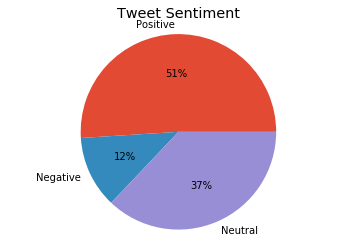

In [37]:
x = np.array([50.9, 11.9, 37.0])
labels = "Positive", "Negative", "Neutral"
plt.pie(x, labels=labels, autopct='%1.0f%%')
plt.axis('equal')
plt.title('Tweet Sentiment')
plt.savefig('Tweet_Sentiment.png')

In [38]:
#create separate dataframes for positive, negative, neutral and all tweets
positive_tweets = pd.concat([processed_docs,ptweets], axis=1, join='inner')
negative_tweets = pd.concat([processed_docs,ntweets], axis=1, join='inner')                         
neutral_tweets = pd.concat([processed_docs,neutweets], axis=1, join='inner')  
all_tweets = pd.concat([processed_docs,alltweets], axis=1, join='inner') 

In [39]:
len(positive_tweets), len(negative_tweets), len(neutral_tweets)

(22294, 5230, 16191)

In [70]:
#select positive tweets same as negative tweets
positive_tweets_smp = positive_tweets.sample(50)
negative_tweets_smp = negative_tweets.sample(50)

In [41]:
(negative_tweets)[:10]

,text_clean,text,index,polarity,sentiment
2,"[bass, isnt, wrong, object]",Bass isnt wrong. He's objective.. which is way...,2,-0.037500,negative
5,"[need, keto, diet, couldn, stay, away, pizza, ...",I need to get back on my keto diet I couldn’t ...,5,-0.125000,negative
12,"[keto, month, drink, black, kerrygold, butter,...",Yes! When I was on keto for a few months I wou...,12,-0.188889,negative
14,"[weird, buy, neighbor, flower, thank, babysit,...",Would it be weird if I bought my neighbor flow...,14,-0.500000,negative
23,"[fuck, hate, work, herbalif, keto, bullshit, f...",i really fucking hate anyone who works for her...,23,-0.281250,negative
37,"[keto, lose, bunch, weight, eat, calori, up]",I ate keto and I lost a bunch of weight- it’s ...,37,-0.208333,negative
57,"[keto, chicken, liver, paté, thyme, butter]",Keto chicken liver paté with thyme butter,57,-0.600000,negative
59,"[celiac, test, come, neg, paleo, year, vegan]",I've had the celiac test and it came back nega...,59,-0.150000,negative
73,"[keto, sell, carb, one, dumb]",are u keto rn or??? bc they sell low carb ones...,73,-0.187500,negative
77,"[barbecu, chicken, pizza, recip, keto, lowcarb...",Barbecue Chicken Pizza Recipe #keto #lowcarb #...,77,-0.600000,negative


In [71]:
#collect all text by sentiment;
all_p_text = []
for word in positive_tweets_smp['text_clean']:
    all_p_text.append(word)
all_p_text = list(itertools.chain.from_iterable(all_p_text))
# print("\n positive:\n", all_p_text)

all_n_text = []
for word in negative_tweets_smp['text_clean']:
    all_n_text.append(word)
all_n_text = list(itertools.chain.from_iterable(all_n_text))
# print("\n negative:\n", all_n_text)

# all_neut_text = []
# for word in neutral_tweets['text_clean']:
#     all_neut_text.append(word)
# all_neut_text = list(itertools.chain.from_iterable(all_neut_text))
# print("\n neutral:\n", all_neut_text)
#collect all text;

all_text = []
for word in all_tweets['text_clean']:
    all_text.append(word)
all_text = list(itertools.chain.from_iterable(all_text))


In [72]:
len(all_p_text), len(all_n_text), len(all_text)

(409, 360, 318199)

In [78]:
# positive tweets feature set
pos_tweets_set = []
for tweet in positive_tweets_smp['text_clean']:
    pos_tweets_set.append((bag_of_words(tweet, all_text), 'pos'))   
    

In [79]:
# negative tweets feature set
neg_tweets_set = []
for tweet in negative_tweets_smp['text_clean']:
    neg_tweets_set.append((bag_of_words(tweet, all_text), 'neg')) 
   

In [ ]:
 
# neutral tweets feature set
# neu_tweets_set = []
# for tweet in neutral_tweets['text_clean']:
#     neu_tweets_set.append((bag_of_words(tweet, all_text), 'neu')) 
    
#all tweets feature set
# all_tweets_set = []
# for tweet in document_v['text_clean']:
#     all_tweets_set.append((bag_of_words(tweet, all_text), 'neu')) 
    
print (len(pos_tweets_set), len(neg_tweets_set))#, len(neu_tweets_set))

In [80]:
pos_tweets_set[:10]

[({'best': True,
   'choic': True,
   'break': True,
   'fast': True,
   'keto': True,
   'ketogen': True,
   'ketosi': True,
   'lchf': True,
   'ketodiet': True,
   'nonsens': True,
   'speak': True,
   'nutritionist': True,
   'doctor': True,
   'askthedoctor': True,
   'tonight': True,
   'roll': True,
   'eye': True,
   'hear': True,
   'unsa': True,
   'easi': True,
   'free': True,
   'tangi': True,
   'lemon': True,
   'cooki': True,
   'recip': True,
   'light': True,
   'eensiv': True,
   'sale': True,
   'bogo': True,
   'delici': True,
   'happi': True,
   'month': True,
   'go': True,
   'marlow': True,
   'jordyn': True,
   'stress': True,
   'end': True,
   'great': True,
   'fledg': True,
   'hardcor': True,
   'strict': True,
   'like': True,
   'lose': True,
   'coffe': True,
   'matter': True,
   'night': True,
   'slimfast': True,
   'brand': True,
   'ambassador': True,
   'amanda': True,
   'plan': True,
   'macro': True,
   'friendli': True,
   'wed': True,
   'm

In [81]:
test_set = pos_tweets_set[:(int(len(pos_tweets_set)*.2))] + neg_tweets_set[:(int(len(neg_tweets_set)*.2))]
train_set = pos_tweets_set[(int(len(pos_tweets_set)*.2)):] + neg_tweets_set[(int(len(neg_tweets_set)*.2)):] 

print(len(test_set),  len(train_set))

20 80


In [82]:
# Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy) 
 

1.0


In [65]:
print (classifier.show_most_informative_features(10)) 

Most Informative Features
               kurdistan = True              neg : pos    =      1.0 : 1.0
                    cozi = True              neg : pos    =      1.0 : 1.0
                acquaint = True              neg : pos    =      1.0 : 1.0
                 micheal = True              neg : pos    =      1.0 : 1.0
                    doll = True              neg : pos    =      1.0 : 1.0
              theologian = True              neg : pos    =      1.0 : 1.0
             caterpillar = True              neg : pos    =      1.0 : 1.0
                    anal = True              neg : pos    =      1.0 : 1.0
                    know = True              neg : pos    =      1.0 : 1.0
                   graem = True              neg : pos    =      1.0 : 1.0
None


In [69]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()

In [66]:
from collections import defaultdict
 
actual_set = defaultdict(set)
predicted_set = defaultdict(set)
 
actual_set_cm = []
predicted_set_cm = []
 
for index, (feature, actual_label) in enumerate(test_set):
    actual_set[actual_label].add(index)
    actual_set_cm.append(actual_label)
 
    predicted_label = classifier.classify(feature)
 
    predicted_set[predicted_label].add(index)
    predicted_set_cm.append(predicted_label)
    
from nltk.metrics import precision, recall, f_measure, ConfusionMatrix
 
print('pos precision:', precision(actual_set['pos'], predicted_set['pos'])) # Output: pos precision: 0.762896825397
print('pos recall:', recall(actual_set['pos'], predicted_set['pos'])) # Output: pos recall: 0.769
print('pos F-measure:', f_measure(actual_set['pos'], predicted_set['pos'])) # Output: pos F-measure: 0.76593625498
 
print('neg precision:', precision(actual_set['neg'], predicted_set['neg'])) # Output: neg precision: 0.767137096774
print('neg recall:', recall(actual_set['neg'], predicted_set['neg'])) # Output: neg recall: 0.761
print('neg F-measure:', f_measure(actual_set['neg'], predicted_set['neg'])) # Output: neg F-measure: 0.7640562249

pos precision: 0.5
pos recall: 1.0
pos F-measure: 0.6666666666666666
neg precision: None
neg recall: 0.0
neg F-measure: None


In [67]:
cm = ConfusionMatrix(actual_set_cm, predicted_set_cm)
print (cm)
print (cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

    |    n    p |
    |    e    o |
    |    g    s |
----+-----------+
neg |   <.>1046 |
pos |    .<1046>|
----+-----------+
(row = reference; col = test)

    |      n      p |
    |      e      o |
    |      g      s |
----+---------------+
neg |     <.> 50.0% |
pos |      . <50.0%>|
----+---------------+
(row = reference; col = test)

